<a href="https://colab.research.google.com/github/Mohammed-Taher6705/jigsaw-puzzle-matching/blob/main/Image_phase_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Mohammed-Taher6705/jigsaw-puzzle-matching.git


Cloning into 'jigsaw-puzzle-matching'...
remote: Enumerating objects: 456, done.
remote: Counting objects: 100% (456/456), done.
remote: Compressing objects: 100% (454/454), done.
remote: Total 456 (delta 2), reused 446 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (456/456), 18.10 MiB | 13.83 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Cell 1: find the zip under /content/jigsaw-puzzle-matching and unzip
import os
from pprint import pprint
base_folder = "/content/jigsaw-puzzle-matching"
zip_candidates = [f for f in os.listdir(base_folder) if f.lower().endswith(".zip")]
print("Zip files found in", base_folder, ":\n", zip_candidates)

if not zip_candidates:
    raise FileNotFoundError("No .zip found in /content/jigsaw-puzzle-matching. Make sure 'Images dataset files.zip' is there.")

# choose the one you added (if multiple, picks first)
zip_name = zip_candidates[0]
zip_path = os.path.join(base_folder, zip_name)
print("Using zip:", zip_path)

extract_to = os.path.join(base_folder, "dataset")

# unzip quietly (handles spaces)
!unzip -q "{zip_path}" -d "{extract_to}"
print("Unzipped to:", extract_to)

print("\nTop-level entries under the extraction folder:")
pprint(sorted(os.listdir(extract_to)))


Zip files found in /content/jigsaw-puzzle-matching :
 ['Images dataset files.zip']
Using zip: /content/jigsaw-puzzle-matching/Images dataset files.zip
Unzipped to: /content/jigsaw-puzzle-matching/dataset

Top-level entries under the extraction folder:
['Gravity Falls', 'correct', 'puzzle_2x2', 'puzzle_4x4', 'puzzle_8x8']


In [11]:
# Cell 2: detect dataset root that contains expected folders
import os
expected = {"correct", "puzzle_2x2", "puzzle_4x4", "puzzle_8x8"}

def has_expected(root):
    if not os.path.isdir(root):
        return False
    entries = set([name for name in os.listdir(root) if os.path.isdir(os.path.join(root, name))])
    return expected.issubset(entries)

EXTRACT_TO = os.path.join("/content","jigsaw-puzzle-matching","dataset")
candidates = [EXTRACT_TO] + [os.path.join(EXTRACT_TO, x) for x in os.listdir(EXTRACT_TO)]

BASE_PATH = None
for c in candidates:
    if has_expected(c):
        BASE_PATH = c
        break

if BASE_PATH is None:
    print("Could not find all expected folders (correct, puzzle_2x2, puzzle_4x4, puzzle_8x8).")
    print("Contents of extraction folder:")
    pprint(sorted(os.listdir(EXTRACT_TO)))
    raise FileNotFoundError("Please inspect the printed contents and ensure the zip contains the expected folders.")
else:
    print("Detected dataset BASE_PATH:", BASE_PATH)
    print("Contents:")
    pprint(sorted(os.listdir(BASE_PATH)))


Detected dataset BASE_PATH: /content/jigsaw-puzzle-matching/dataset
Contents:
['Gravity Falls', 'correct', 'puzzle_2x2', 'puzzle_4x4', 'puzzle_8x8']


correct: 110 images loaded from /content/jigsaw-puzzle-matching/dataset/correct
puzzle_2x2: 110 images loaded from /content/jigsaw-puzzle-matching/dataset/puzzle_2x2
puzzle_4x4: 110 images loaded from /content/jigsaw-puzzle-matching/dataset/puzzle_4x4
puzzle_8x8: 110 images loaded from /content/jigsaw-puzzle-matching/dataset/puzzle_8x8


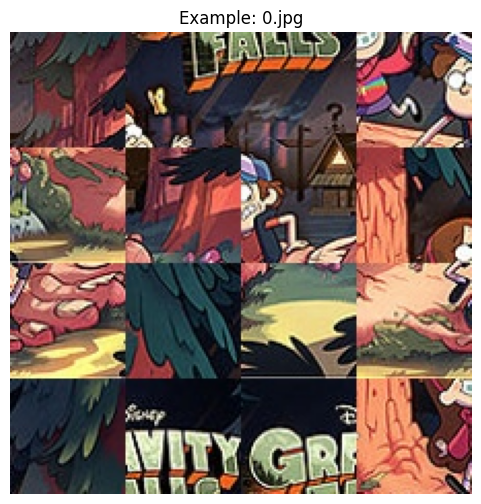

In [12]:
# Cell 3: load images and preview one example
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt

paths = {
    "correct":      os.path.join(BASE_PATH, "correct"),
    "puzzle_2x2":   os.path.join(BASE_PATH, "puzzle_2x2"),
    "puzzle_4x4":   os.path.join(BASE_PATH, "puzzle_4x4"),
    "puzzle_8x8":   os.path.join(BASE_PATH, "puzzle_8x8"),
}

def load_images_from_folder(folder_path):
    # accept common image extensions
    exts = ("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff")
    image_paths = []
    for e in exts:
        image_paths.extend(sorted(glob(os.path.join(folder_path, e))))
    images = []
    for p in image_paths:
        img = cv2.imread(p)
        if img is not None:
            images.append((os.path.basename(p), img, p))
    return images

datasets = {}
for name, path in paths.items():
    if os.path.isdir(path):
        datasets[name] = load_images_from_folder(path)
    else:
        datasets[name] = []
    print(f"{name}: {len(datasets[name])} images loaded from {path}")

# preview one image from puzzle_4x4 if available
if datasets["puzzle_4x4"]:
    fname, sample, fullpath = datasets["puzzle_4x4"][0]
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
    plt.title(f"Example: {fname}")
    plt.axis("off")
else:
    print("No images found in puzzle_4x4 to preview.")
